# Chapter 01, in Java

In [1]:
/* 
 * This jar is compiled from Project-Trunk/System-Languages
 * ../../gradlew build
 * cp build/libs/System-Languages-1.0.jar .
 */
%classpath add jar ../System-Languages-1.0.jar

In [2]:
// Verify if the classpath bove is taken in account
import matrix.SquareMatrix;
import matrix.SystemUtil;

import java.util.concurrent.atomic.AtomicInteger;

In [3]:
// %maven org.knowm.xchart:xchart:3.6.5
%maven org.knowm.xchart:xchart:3.7.0
import org.knowm.xchart.*;
import org.knowm.xchart.style.*;
// Doc at https://knowm.org/javadocs/xchart/index.html

In [4]:
System.out.printf("Running from folder %s%n", System.getProperty("user.dir"));
System.out.printf("Java version %s%n", System.getProperty("java.version"));

Running from folder /Users/olivierlediouris/repos/MathForProgrammersForked/Chapter 01
Java version 11.0.8


java.io.PrintStream@650f1c5e

In [5]:
// Utility classes
static class Tuple {
  double x, y;
  public Tuple(double x, double y) {
    this.x = x;
    this.y = y;
  }
}

private static class IndexedCoeff {
  int idx;
  double coef;
  public IndexedCoeff(int idx, double coef) {
    this.idx = idx;
    this.coef = coef;
  }
}


In [6]:
final String FIGURES_FOLDER = "figures";
File figuresDir = new File(FIGURES_FOLDER);
if (!figuresDir.exists()) {
  System.out.printf("Creating folder %s.", FIGURES_FOLDER);
  figuresDir.mkdirs();
} else {
  System.out.printf("%s folder already exists.", FIGURES_FOLDER);
}

figures folder already exists.

### Creating Random Data

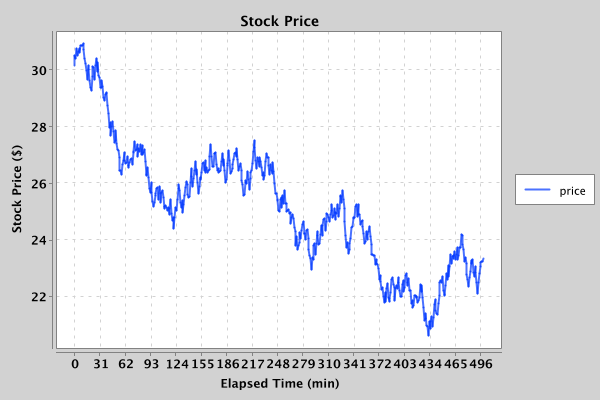

In [7]:
double previousY = 30d;  // Y starts here
double yAmpl = 42d;      // Y amplitude
List<Double> xs = new ArrayList<>();
List<Double> ys = new ArrayList<>();
for (double x=0; x<501; x++) {
  xs.add(x);
  double delta = Math.random() - 0.5;  // [-0.5, 0.5]
  double nextY = previousY + delta;
  if (nextY > yAmpl || nextY < 0) {
    nextY = previousY - delta;
  }
  ys.add(nextY);
  previousY = nextY;
}

double[] xData = xs.stream()
                   .mapToDouble(Double::doubleValue)
                   .toArray();
double[] yData = ys.stream()
                   .mapToDouble(Double::doubleValue)
                   .toArray();

// Plot the data
XYChart chart = QuickChart.getChart(
    "Stock Price",        // Chart title
    "Elapsed Time (min)", // x axis label
    "Stock Price ($)",    // y axis label
    "price",              // Legend
    xData,                // x axis data 
    yData);               // y axis data

// Save it
BitmapEncoder.saveBitmap(chart, "./figures/chart_01", BitmapEncoder.BitmapFormat.PNG);
VectorGraphicsEncoder.saveVectorGraphic(chart, "./figures/chart_01", VectorGraphicsEncoder.VectorGraphicsFormat.SVG);

// Render the chart
BitmapEncoder.getBufferedImage(chart);

// Alternate: Show it (in a swing frame)
// new SwingWrapper(chart).displayChart();



### Finding the closest line
Requires the import from classpath above.

In [8]:
// Regression
final int REQUIRED_SMOOTHING_DEGREE = 1;
int dimension = REQUIRED_SMOOTHING_DEGREE + 1;
double[] sumXArray = new double[(REQUIRED_SMOOTHING_DEGREE * 2) + 1]; // Will fill the matrix
double[] sumY      = new double[REQUIRED_SMOOTHING_DEGREE + 1];
// init
for (int i=0; i<((REQUIRED_SMOOTHING_DEGREE * 2) + 1); i++) {
  sumXArray[i] = 0.0;
}
for (int i=0; i<(REQUIRED_SMOOTHING_DEGREE + 1); i++) {
  sumY[i] = 0.0;
}
List<Tuple> data = new ArrayList<>();
for (int x=0; x<xData.length; x++) {
    data.add(new Tuple(xData[x], yData[x]));
}
data.stream().forEach(tuple -> {
  for (int i=0; i<((REQUIRED_SMOOTHING_DEGREE * 2) + 1); i++) {
    sumXArray[i] += Math.pow(tuple.x, i);
  }
  for (int i=0; i<(REQUIRED_SMOOTHING_DEGREE + 1); i++) {
    sumY[i] += (tuple.y * Math.pow(tuple.x, i));
  }
});

In [9]:
SquareMatrix squareMatrix = new SquareMatrix(dimension);
for (int row=0; row<dimension; row++) {
  for (int col=0; col<dimension; col++) {
    int powerRnk = (REQUIRED_SMOOTHING_DEGREE - row) + (REQUIRED_SMOOTHING_DEGREE - col);
    System.out.println("[" + row + "," + col + ": deg " + (powerRnk) + "] = " + sumXArray[powerRnk]);
    squareMatrix.setElementAt(row, col, sumXArray[powerRnk]);
  }
}
double[] constants = new double[dimension];
for (int i=0; i<dimension; i++) {
  constants[i] = sumY[REQUIRED_SMOOTHING_DEGREE - i];
  System.out.println("[" + (REQUIRED_SMOOTHING_DEGREE - i) + "] = " + constants[i]);
}

System.out.println("Resolving:");
SystemUtil.printSystem(squareMatrix, constants);
System.out.println();

double[] result = SystemUtil.solveSystem(squareMatrix, constants);


[0,0: deg 2] = 4.179175E7
[0,1: deg 1] = 125250.0
[1,0: deg 1] = 125250.0
[1,1: deg 0] = 501.0
[1] = 3012698.7768655284
[0] = 12626.794390621548
Resolving:
(41791750.000000 x A) + (125250.000000 x B) = 3012698.776866
(125250.000000 x A) + (501.000000 x B) = 12626.794391



In [10]:
AtomicInteger integer = new AtomicInteger(0);
// Final equation coefficients:
Arrays.stream(result)
      .boxed()
      .map(coef -> new IndexedCoeff(integer.incrementAndGet(), coef))
      .forEach(ic -> System.out.println(String.format("Deg %d -> %f", (dimension - ic.idx), ic.coef)));

Deg 1 -> -0.013741
Deg 0 -> 28.638538


### Display raw and smoothed data

In [11]:
List<Double> ySmoothed = new ArrayList<>();

xs.forEach(x -> {
  double y = (x * result[0]) + result[1];
  ySmoothed.add(y);
});

double[] yDataSmoothed = ySmoothed.stream()
                   .mapToDouble(Double::doubleValue)
                   .toArray();

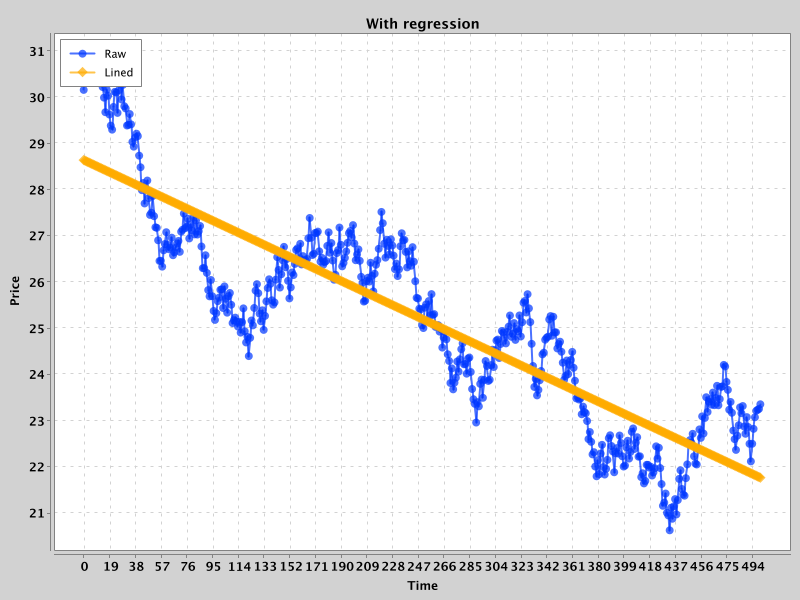

In [12]:
XYChart chart = new XYChartBuilder()
                         .width(800)
                         .height(600)
                         .title("With regression")
                         .xAxisTitle("Time")
                         .yAxisTitle("Price")
                         .build();
 
    // Customize Chart
    chart.getStyler().setLegendPosition(Styler.CardinalPosition.InsideNW);
    // chart.getStyler().setDefaultSeriesRenderStyle(XYStyler.XYSeries.XYSeriesRenderStyle.Line);
    // chart.getStyler().setYAxisLabelAlignment(Styler.TextAlignment.Right);
    // chart.getStyler().setYAxisDecimalPattern("$ #,###.##");
    // chart.getStyler().setPlotMargin(0);
    // chart.getStyler().setPlotContentSize(.95);
    
XYSeries seriesLiability = chart.addSeries("Raw", xData, yData);
// seriesLiability.setChartXYSeriesRenderStyle(XYSeries.XYSeriesRenderStyle.Area);
// seriesLiability.setMarker(SeriesMarkers.NONE);    

chart.addSeries("Lined", xData, yDataSmoothed);

// Render the chart
BitmapEncoder.getBufferedImage(chart);